<a href="https://colab.research.google.com/github/seoyeon2200/25-1_Pattern-Recognition/blob/main/%ED%8C%A8%ED%84%B4%EC%9D%B8%EC%8B%9D_%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1%2C%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#패턴인식 12팀
###  로지스틱, 랜덤 포레스트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###이상치 탐지 및 처리
- 초기에는 IQR/Z-score 등으로 처리하려고 했으나, 이상치가 너무 많았음 - 확인해보니 컬럼별로 다양하게 값이 존재할 수 있었음 ( ex 공유 횟수, 단어 갯수 등등 - 도메인이 아주 넓어도 상관없는 컬럼들이 존재함)
- 컬럼별 도메인을 파악하여 이상치를 처리하기로 함

In [ ]:
# 라이브러리 가져오기
import pandas as pd
import numpy as np

# 데이터 전처리 라이브러리
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def clean_by_domain(df, remove_rows=True, verbose=True):
    # 도메인 정의 (kw 관련 변수는 -1 이상 허용)
    domain_rules = {
        'n_tokens_title': [0, None],
        'n_tokens_content': [0, None],
        'n_unique_tokens': [0, 1],
        'n_non_stop_words': [0, 1],
        'n_non_stop_unique_tokens': [0, 1],
        'num_hrefs': [0, None],
        'num_self_hrefs': [0, None],
        'num_imgs': [0, None],
        'num_videos': [0, None],
        'average_token_length': [0, None],
        'num_keywords': [0, None],
    }

    # kw_* 변수는 -1 이상 허용
    kw_columns = [f'kw_{stat}_{agg}' for stat in ['min', 'max', 'avg'] for agg in ['min', 'max', 'avg']]
    for col in kw_columns:
        domain_rules[col] = [-1, None]  # -1 이상으로 허용

    # Self-reference
    domain_rules.update({
        'self_reference_min_shares': [0, None],
        'self_reference_max_shares': [0, None],
        'self_reference_avg_sharess': [0, None],
    })

    # LDA 주제 확률
    for i in range(5):
        domain_rules[f'LDA_0{i}'] = [0, 1]

    # 감성/주관성 변수
    domain_rules.update({
        'global_subjectivity': [0, 1],
        'global_sentiment_polarity': [-1, 1],
        'global_rate_positive_words': [0, 1],
        'global_rate_negative_words': [0, 1],
        'rate_positive_words': [0, 1],
        'rate_negative_words': [0, 1],
        'avg_positive_polarity': [0, 1],
        'min_positive_polarity': [0, 1],
        'max_positive_polarity': [0, 1],
        'avg_negative_polarity': [-1, 0],
        'min_negative_polarity': [-1, 0],
        'max_negative_polarity': [-1, 0],
        'title_subjectivity': [0, 1],
        'title_sentiment_polarity': [-1, 1],
        'abs_title_subjectivity': [0, 1],
        'abs_title_sentiment_polarity': [0, 1],
    })

    df_cleaned = df.copy()
    total_outliers = 0

    for col, (min_val, max_val) in domain_rules.items():
        if col in df_cleaned.columns:
            outliers = pd.Series(False, index=df_cleaned.index)
            if min_val is not None:
                outliers |= df_cleaned[col] < min_val
            if max_val is not None:
                outliers |= df_cleaned[col] > max_val

            outlier_count = outliers.sum()
            total_outliers += outlier_count

            if verbose and outlier_count > 0:
                print(f"[{col}] 이상치 {outlier_count}개 발견")

            # 처리 방법 결정
            if remove_rows:
                df_cleaned = df_cleaned.loc[~outliers]
            else:
                df_cleaned.loc[outliers, col] = np.nan

    if verbose:
        if remove_rows:
            print(f"\n[총 제거된 행 수]: {total_outliers}")
        else:
            print(f"\n[총 NaN 처리된 이상치 수]: {total_outliers}")

    return df_cleaned



# 데이터 불러오기
train = pd.read_csv('train.csv')
train_cleaned = clean_by_domain(train, remove_rows=True)




[총 제거된 행 수]: 0


###결측값 처리
- 결측값 처리를 위하여 KNN 방식을 사용함
- int/float 형 변수는 KNN 방식을 사용하여 neighbor의 갯수를 5개로 하여 관측한 결과를 적용
- string 변수는 NaN 값에 대해서 Unknown으로 변환함

In [ ]:
def impute_all_columns(df, n_neighbors=5, verbose=True):
    # 1. 문자열/범주형 컬럼 처리 ('Unknown'으로 대체)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        missing_count = df[col].isnull().sum()
        if missing_count > 0 and verbose:
            print(f"[{col}] 문자열 결측치 {missing_count}개 → 'Unknown'으로 대체")
        df[col].fillna('Unknown', inplace=True)

    # 2. 수치형 컬럼 처리 (KNN Imputer + 표준화)
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[num_cols])

    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_scaled = imputer.fit_transform(scaled_data)

    # 역표준화 후 반영
    imputed_data = scaler.inverse_transform(imputed_scaled)
    df[num_cols] = pd.DataFrame(imputed_data, columns=num_cols, index=df.index)

    if verbose:
        print("\n결측치 처리가 완료되었습니다!")

    return df

train_final = impute_all_columns(train_cleaned, n_neighbors=5)

[data_channel] 문자열 결측치 2147개 → 'Unknown'으로 대체
[weekday] 문자열 결측치 2113개 → 'Unknown'으로 대체


<ipython-input-3-f175d4b57076>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)



결측치 처리가 완료되었습니다!


### String 변수 인코딩
- 통계랑 계산을 위해 int 형태로 변환


In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_string_columns(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    le_dict = {}  # 인코더 저장

    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # 인코더 저장 (나중에 디코딩할 때 사용 가능)

    return df, le_dict

train_encoded, le_dict = encode_string_columns(train_final)

### 통계량 계산
- 데이터 통계량 계산 ( 평균 / 표준편차 / 중위수 / 사분위값 / min / max )

In [ ]:
def calculate_statistics(df, exclude_columns=['id', 'shares', 'y']):
    # 수치형 변수만 선택
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                    if col not in exclude_columns]

    # 통계량 계산
    stats_df = df[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75]).transpose()

    # 컬럼 이름 재정의
    stats_df = stats_df.rename(columns={
        'mean': '평균',
        'std': '표준편차',
        'min': '최솟값',
        '25%': '1사분위수(Q1)',
        '50%': '중위수(중간값)',
        '75%': '3사분위수(Q3)',
        'max': '최댓값'
    })

    # 원하는 순서로 재배치
    stats_df = stats_df[['평균', '표준편차', '최솟값', '1사분위수(Q1)', '중위수(중간값)', '3사분위수(Q3)', '최댓값']]

    # print("\n[데이터 통계량 요약]")
    # print(stats_df.round(4).to_string())

    return stats_df

calculate_statistics(train_encoded)

,평균,표준편차,최솟값,1사분위수(Q1),중위수(중간값),3사분위수(Q3),최댓값
n_tokens_title,10.390658,2.027269,3.000000e+00,9.000000,10.000000,12.000000,19.000000
n_tokens_content,544.850054,449.570686,0.000000e+00,253.000000,419.000000,714.400000,7413.000000
n_unique_tokens,0.530380,0.135686,0.000000e+00,0.473345,0.539623,0.606242,1.000000
n_non_stop_words,0.969856,0.170967,-1.110223e-16,1.000000,1.000000,1.000000,1.000000
n_non_stop_unique_tokens,0.673101,0.152666,0.000000e+00,0.630070,0.691517,0.751479,1.000000
num_hrefs,10.794108,10.664199,0.000000e+00,5.000000,8.000000,13.400000,186.000000
num_self_hrefs,3.295658,3.796881,0.000000e+00,1.000000,3.000000,4.000000,116.000000
num_imgs,4.426216,7.849296,0.000000e+00,1.000000,1.000000,4.000000,108.000000
num_videos,1.241279,3.960467,0.000000e+00,0.000000,0.000000,1.000000,91.000000
average_token_length,4.548023,0.846367,0.000000e+00,4.490151,4.665706,4.846567,8.041534


###전처리된 데이터 시각화
- 각 변수별 히스토그램
- 변수 간 관계 => 산점도행렬 => 너무 복잡해서 보기 힘듦 - 피어슨상관계수 히트맵으로 나타내기


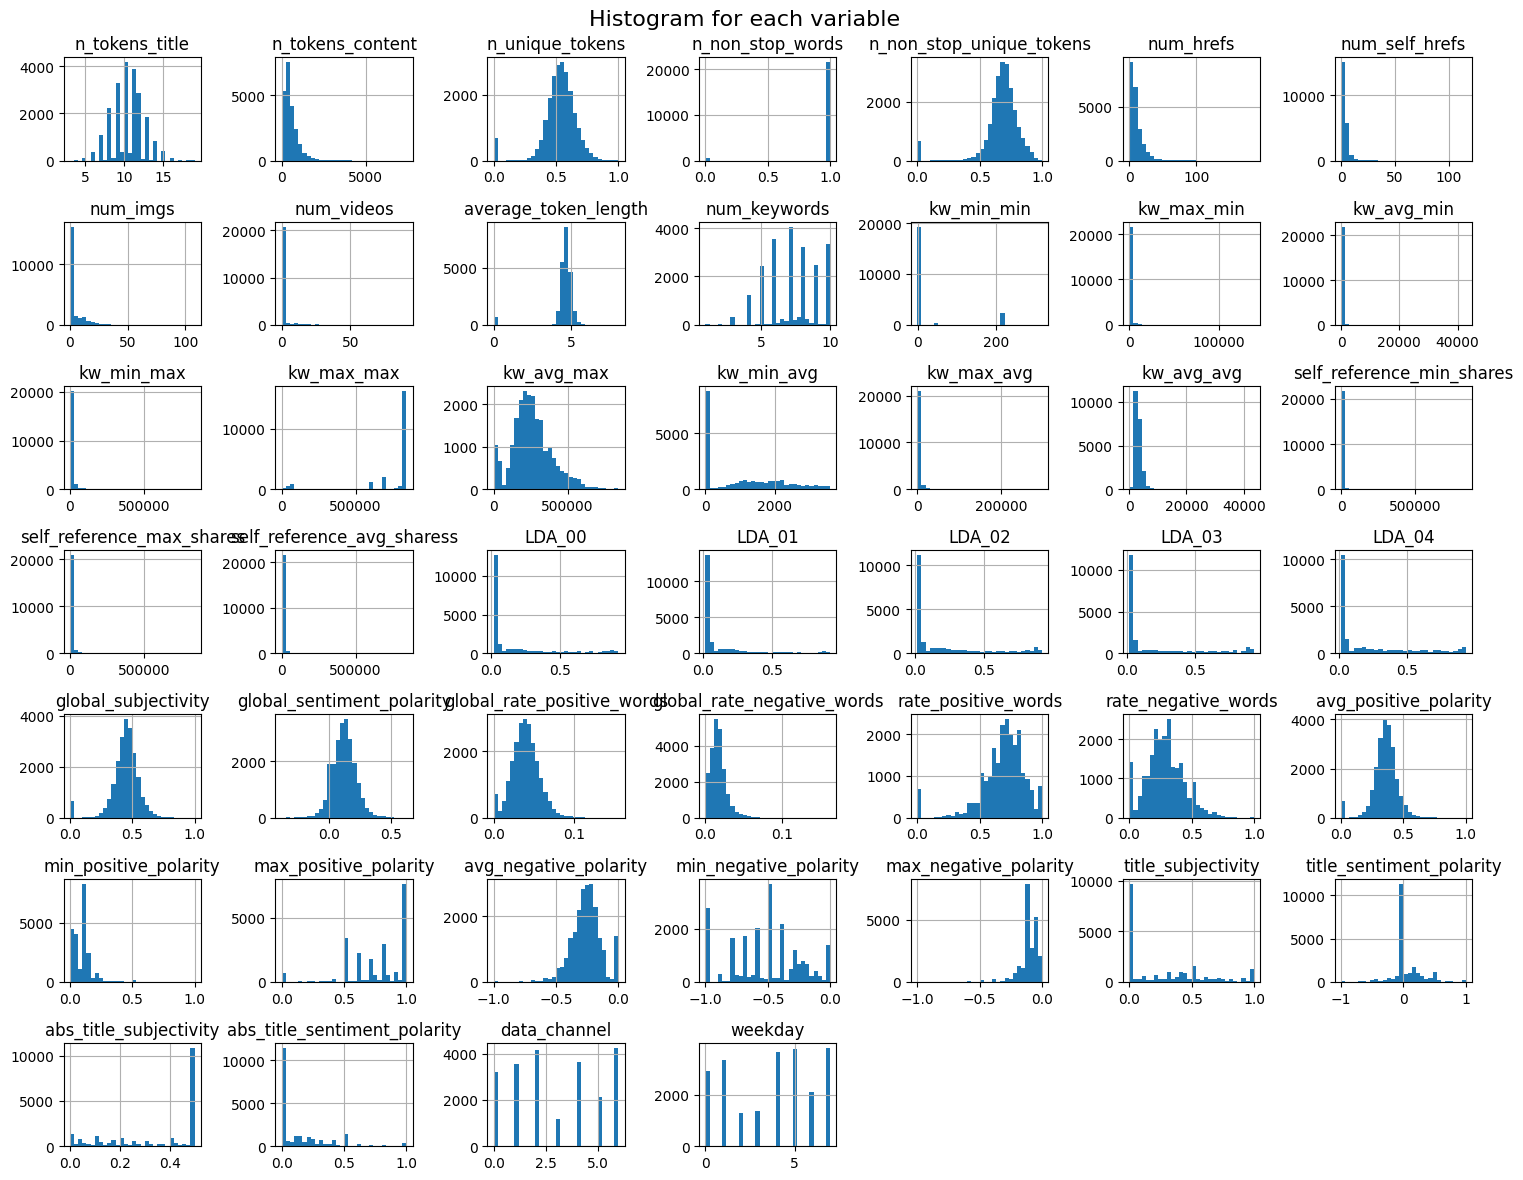

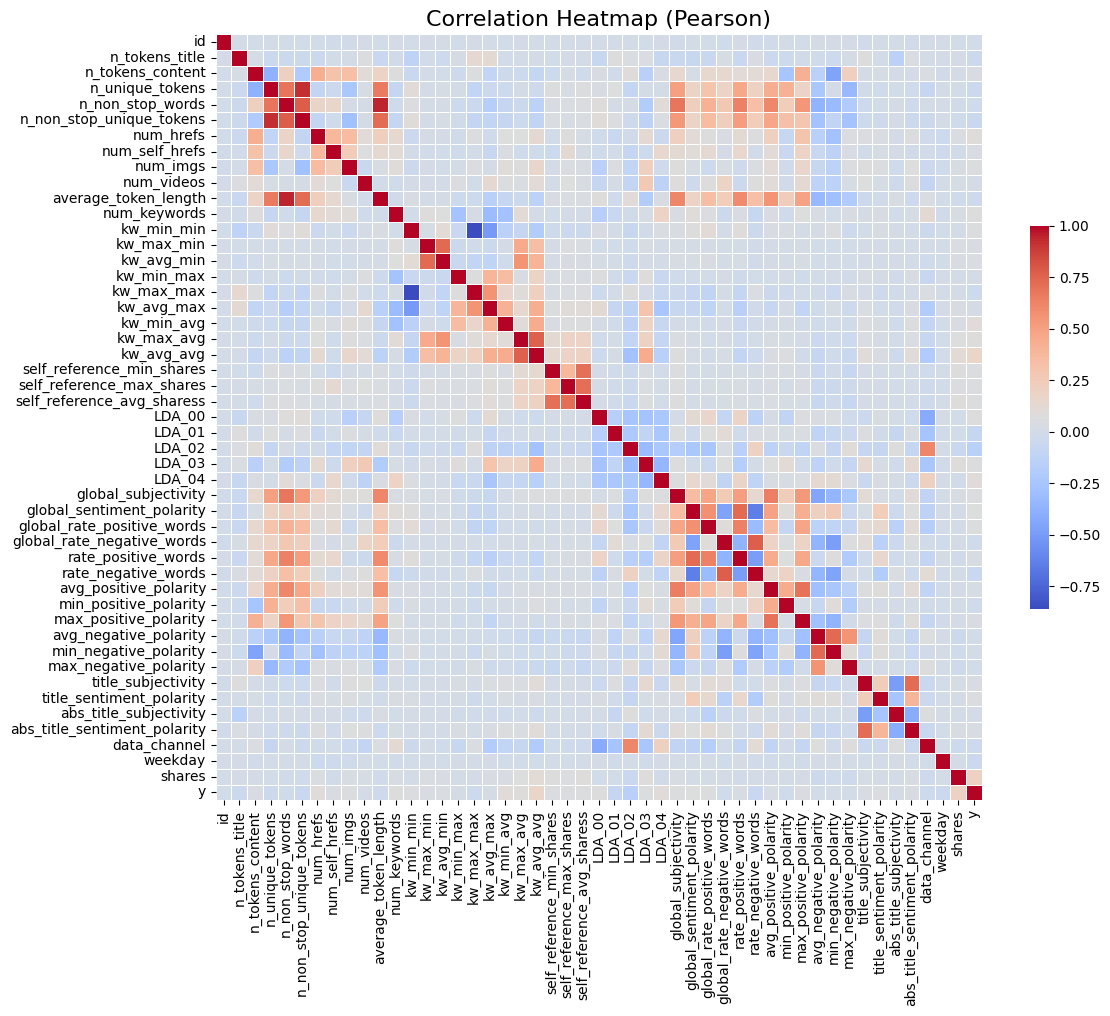

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histograms(df, exclude_columns=['id', 'shares', 'y'], bins=30):
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns
                    if col not in exclude_columns]
    df[numeric_cols].hist(bins=bins, figsize=(15, 12))
    plt.suptitle("Histogram for each variable", fontsize=16)
    plt.tight_layout()
    plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(df, method='pearson', top_n=None, figsize=(12, 10), cmap='coolwarm'):
    corr_matrix = df.corr(method=method)

    if top_n is not None:
        corr_abs = corr_matrix.abs()
        upper_tri = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
        top_pairs = (upper_tri.stack()
                                .sort_values(ascending=False)
                                .head(top_n)
                                .index)
        top_vars = set(sum(top_pairs, ()))
        corr_matrix = corr_matrix.loc[top_vars, top_vars]

    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=False, cmap=cmap, linewidths=0.5, square=True, cbar_kws={"shrink": .5})
    plt.title(f"Correlation Heatmap ({method.title()})", fontsize=16)
    plt.tight_layout()
    plt.show()



plot_histograms(train_encoded)
# 전체 변수로 Heatmap
plot_heatmap(train_encoded)



## 로지스틱 회귀 학습 및 평가

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# 전처리된 학습 데이터 사용
# 1. 타겟 변수 생성
# shares가 1400 이상이면 1, 아니면 0으로 설정
train_encoded['y'] = (train_encoded['shares'] >= 1400).astype(int)

# 2. 특성과 타겟 분리
# 'id', 'shares', 'y'는 입력에 필요 없으므로 제거하고, y는 앞서 만든 'y' 컬럼 사용
X_logreg = train_encoded.drop(columns=['id', 'shares', 'y'])
y_logreg = train_encoded['y']

# 3. 학습/검증 세트 분할
# 데이터 80%는 학습용, 20%는 검증용으로 분할
X_train_logreg, X_valid_logreg, y_train_logreg, y_valid_logreg = train_test_split(
    X_logreg, y_logreg, test_size=0.2, random_state=42, stratify=y_logreg
)

# 4. 특성 스케일링 (정규화)
# 숫자의 크기를 맞추는 과정
scaler_logreg = StandardScaler()
X_train_scaled_logreg = scaler_logreg.fit_transform(X_train_logreg)
X_valid_scaled_logreg = scaler_logreg.transform(X_valid_logreg)

# 5. 모델 정의 및 학습
# 반복 횟수 최대 1000회로 설정
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_scaled_logreg, y_train_logreg)

# 6. 검증 세트 예측
# 이진 예측 결과와 확률값 추출
valid_pred_logreg = log_reg_model.predict(X_valid_scaled_logreg)
valid_prob_logreg = log_reg_model.predict_proba(X_valid_scaled_logreg)[:, 1]

# 7. 평가
# 정확도, F1 점수, AUC 계산 후 평균 점수 계산
acc_logreg = accuracy_score(y_valid_logreg, valid_pred_logreg)
f1_logreg = f1_score(y_valid_logreg, valid_pred_logreg)
auc_logreg = roc_auc_score(y_valid_logreg, valid_prob_logreg)
final_score_logreg = (acc_logreg + f1_logreg + auc_logreg) / 3

print(f"\n[로지스틱 회귀 평가 결과]")
print(f"정확도: {acc_logreg:.4f}")
print(f"F1 점수: {f1_logreg:.4f}")
print(f"AUC: {auc_logreg:.4f}")
print(f"평균 점수: {final_score_logreg:.4f}")

# 8. 테스트 데이터 처리
test = pd.read_csv('test.csv')
test_cleaned = clean_by_domain(test, remove_rows=True)
test_final = impute_all_columns(test_cleaned, n_neighbors=5)
test_encoded, _ = encode_string_columns(test_final)

# 9. 테스트 예측
# 예측 결과를 저장할 id만 따로 저장, 'id' 컬럼은 예측에 필요 없으므로 제외
test_ids_logreg = test_encoded['id']
X_test_logreg = test_encoded.drop(columns=['id'])
X_test_scaled_logreg = scaler_logreg.transform(X_test_logreg) # 정규화

# 로지스틱 회귀 모델을 사용해 테스트 데이터 예측
test_pred_logreg = log_reg_model.predict(X_test_scaled_logreg)
test_prob_logreg = log_reg_model.predict_proba(X_test_scaled_logreg)[:, 1]

# 10. 결과 저장
# 예측 결과와 확률을 함께 저장하여 CSV 파일로 출력
submission_logreg = pd.DataFrame({
    'id': test_ids_logreg,
    'y_predict': test_pred_logreg,
    'y_prob': test_prob_logreg
})
submission_logreg.to_csv('prediction_logreg.csv', index=False)
print("\n[prediction_logreg.csv] 저장 완료 (로지스틱 회귀 결과)")


[로지스틱 회귀 평가 결과]
정확도: 0.6342
F1 점수: 0.6707
AUC: 0.6750
평균 점수: 0.6600
[n_unique_tokens] 이상치 1개 발견

[총 제거된 행 수]: 1
[data_channel] 문자열 결측치 962개 → 'Unknown'으로 대체
[weekday] 문자열 결측치 958개 → 'Unknown'으로 대체


<ipython-input-3-f175d4b57076>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)



결측치 처리가 완료되었습니다!

[prediction_logreg.csv] 저장 완료 (로지스틱 회귀 결과)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# 1. 타겟 변수 생성
train_encoded['y'] = (train_encoded['shares'] >= 1400).astype(int)

# 2. 특성과 타겟 분리
X = train_encoded.drop(columns=['id', 'shares', 'y'])
y = train_encoded['y']

# 3. 학습/검증 세트 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# 5. 변수 선택 (L1 정규화로 중요 특성 선택)
feature_selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=1.0)
)
feature_selector.fit(X_train_scaled, y_train)
X_train_selected = feature_selector.transform(X_train_scaled)
X_valid_selected = feature_selector.transform(X_valid_scaled)

# 6. 하이퍼파라미터 튜닝 + 클래스 불균형 보정
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}
grid_model = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_model.fit(X_train_selected, y_train)
best_model = grid_model.best_estimator_

# 7. 예측 및 평가
valid_pred = best_model.predict(X_valid_selected)
valid_prob = best_model.predict_proba(X_valid_selected)[:, 1]

acc = accuracy_score(y_valid, valid_pred)
f1 = f1_score(y_valid, valid_pred)
auc = roc_auc_score(y_valid, valid_prob)
final_score = (acc + f1 + auc) / 3

print(f"\n[튜닝된 로지스틱 회귀 평가 결과]")
print(f"정확도: {acc:.4f}")
print(f"F1 점수: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"평균 점수: {final_score:.4f}")

# 8. 테스트 데이터 처리
test = pd.read_csv('test.csv')
test_cleaned = clean_by_domain(test, remove_rows=True)
test_final = impute_all_columns(test_cleaned, n_neighbors=5)
test_encoded, _ = encode_string_columns(test_final)

# 9. 테스트 데이터 전처리 및 예측
test_ids = test_encoded['id']
X_test = test_encoded.drop(columns=['id'])
X_test_scaled = scaler.transform(X_test)
X_test_selected = feature_selector.transform(X_test_scaled)

test_pred = best_model.predict(X_test_selected)
test_prob = best_model.predict_proba(X_test_selected)[:, 1]

# 10. 결과 저장
submission = pd.DataFrame({
    'id': test_ids,
    'y_predict': test_pred,
    'y_prob': test_prob
})
submission.to_csv('prediction_logreg.csv', index=False)
print("\n[prediction_logreg.csv] 저장 완료 (최적화된 로지스틱 회귀 결과)")


[튜닝된 로지스틱 회귀 평가 결과]
정확도: 0.6243
F1 점수: 0.6655
AUC: 0.6634
평균 점수: 0.6510
[n_unique_tokens] 이상치 1개 발견

[총 제거된 행 수]: 1
[data_channel] 문자열 결측치 962개 → 'Unknown'으로 대체
[weekday] 문자열 결측치 958개 → 'Unknown'으로 대체


<ipython-input-17-f175d4b57076>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)



결측치 처리가 완료되었습니다!

[prediction_logreg.csv] 저장 완료 (최적화된 로지스틱 회귀 결과)


##랜덤 포레스트 학습 및 평가

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

# 전처리된 학습 데이터 사용
# 1. 타겟 변수 생성
# shares가 1400 이상이면 1, 아니면 0으로 설정
train_encoded["y"] = (train_encoded["shares"] >= 1400).astype(int)

# 2. 특성과 타겟 분리
# 'id', 'shares', 'y'는 입력에 필요 없으므로 제거하고, y는 앞서 만든 'y' 컬럼 사용
X_rf = train_encoded.drop(columns=["id", "shares", "y"])
y_rf = train_encoded["y"]

# 3. 학습/검증 세트 분할
# 데이터 80%는 학습용, 20%는 검증용으로 분할
X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

# 4. 랜덤 포레스트 모델 정의 및 그리드서치, 평가 지표는 ROC AUC
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42)

param_grid_rf = { # 실험할 파라미터 조합 정의
    "n_estimators": [100, 200],  # 트리 개수
    "max_features": [0.5, "sqrt", "log2", None],  # 각 트리에서 사용할 특성 수
}

cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 교차 검증 설정


# 그리드서치 객체 정의
grid_search_rf = GridSearchCV(
    model_rf,
    param_grid_rf,
    scoring="roc_auc",
    cv=cv_rf,
    refit=True,
    n_jobs=-1,
    verbose=1
)

# 학습 데이터로 그리드서치 수행
grid_search_rf.fit(X_train_rf, y_train_rf)

# 5. 평가
# 최적 모델을 검증 데이터에 적용하여 성능 측정
best_rf_model = grid_search_rf.best_estimator_
valid_pred_rf = best_rf_model.predict(X_valid_rf)
valid_prob_rf = best_rf_model.predict_proba(X_valid_rf)[:, 1]

# 정확도, F1 점수, AUC 계산 후 평균 점수 계산
acc_rf = accuracy_score(y_valid_rf, valid_pred_rf)
f1_rf = f1_score(y_valid_rf, valid_pred_rf)
auc_rf = roc_auc_score(y_valid_rf, valid_prob_rf)
final_score_rf = (acc_rf + f1_rf + auc_rf) / 3

print(f"\n[랜덤 포레스트 평가 결과]")
print(f"Best Params: {grid_search_rf.best_params_}")
print(f"정확도: {acc_rf:.4f}")
print(f"F1 점수: {f1_rf:.4f}")
print(f"AUC: {auc_rf:.4f}")
print(f"평균 점수: {final_score_rf:.4f}")

# 6. 테스트 데이터 처리
test = pd.read_csv('test.csv')
test_cleaned = clean_by_domain(test, remove_rows=True)
test_final = impute_all_columns(test_cleaned, n_neighbors=5)
test_encoded, _ = encode_string_columns(test_final)

# 테스트 데이터에서 ID 제외한 입력값만 모델에 넣고 예측 수행
test_ids_rf = test_encoded["id"]
X_test_rf = test_encoded.drop(columns=["id"])
test_pred_rf = best_rf_model.predict(X_test_rf)
test_prob_rf = best_rf_model.predict_proba(X_test_rf)[:, 1]

# 7. 결과 저장
# 예측 결과와 확률을 함께 저장하여 CSV 파일로 출력
submission_rf = pd.DataFrame({
    "id": test_ids_rf,
    "y_predict": test_pred_rf,
    "y_prob": test_prob_rf
})
submission_rf.to_csv("prediction_rf.csv", index=False)
print("\n[prediction_rf.csv] 저장 완료 (랜덤 포레스트 결과)")

Fitting 5 folds for each of 8 candidates, totalling 40 fits

[랜덤 포레스트 평가 결과]
Best Params: {'max_features': 'sqrt', 'n_estimators': 200}
정확도: 0.6599
F1 점수: 0.6975
AUC: 0.7120
평균 점수: 0.6898
[n_unique_tokens] 이상치 1개 발견

[총 제거된 행 수]: 1
[data_channel] 문자열 결측치 962개 → 'Unknown'으로 대체
[weekday] 문자열 결측치 958개 → 'Unknown'으로 대체


<ipython-input-3-f175d4b57076>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)



결측치 처리가 완료되었습니다!

[prediction_rf.csv] 저장 완료 (랜덤 포레스트 결과)


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

# 1. 타겟 변수 생성
train_encoded["y"] = (train_encoded["shares"] >= 1400).astype(int)

# 2. 특성과 타겟 분리
X = train_encoded.drop(columns=["id", "shares", "y"])
y = train_encoded["y"]

# 3. 학습/검증 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. 하이퍼파라미터 탐색 범위 축소 + 랜덤서치
param_dist = {
    "n_estimators": [100, 150, 200],
    "max_depth": [10, 15, 20],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 5. 탐색 수행
random_rf.fit(X_train, y_train)
best_rf = random_rf.best_estimator_

# 6. 평가
valid_pred = best_rf.predict(X_valid)
valid_prob = best_rf.predict_proba(X_valid)[:, 1]

acc = accuracy_score(y_valid, valid_pred)
f1 = f1_score(y_valid, valid_pred)
auc = roc_auc_score(y_valid, valid_prob)
final_score = (acc + f1 + auc) / 3

print(f"\n[랜덤 포레스트 평가 결과]")
print(f"Best Params: {random_rf.best_params_}")
print(f"정확도: {acc:.4f}")
print(f"F1 점수: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"평균 점수: {final_score:.4f}")

# 7. 테스트 예측
test = pd.read_csv('test.csv')
test_cleaned = clean_by_domain(test, remove_rows=True)
test_final = impute_all_columns(test_cleaned, n_neighbors=5)
test_encoded, _ = encode_string_columns(test_final)

# 테스트 데이터에서 ID 제외한 입력값만 모델에 넣고 예측 수행
test_ids_rf = test_encoded["id"]
X_test_rf = test_encoded.drop(columns=["id"])
test_pred_rf = best_rf.predict(X_test_rf)
test_prob_rf = best_rf.predict_proba(X_test_rf)[:, 1]

submission_rf = pd.DataFrame({
    "id": test_ids_rf,
    "y_predict": test_pred_rf,
    "y_prob": test_prob_rf
})
submission_rf.to_csv("prediction_rf.csv", index=False)
print("\n[prediction_rf.csv] 저장 완료 (랜덤 포레스트  최적화 결과)")


Fitting 5 folds for each of 10 candidates, totalling 50 fits

[랜덤 포레스트 평가 결과]
Best Params: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}
정확도: 0.6606
F1 점수: 0.7003
AUC: 0.7155
평균 점수: 0.6921
[n_unique_tokens] 이상치 1개 발견

[총 제거된 행 수]: 1
[data_channel] 문자열 결측치 962개 → 'Unknown'으로 대체
[weekday] 문자열 결측치 958개 → 'Unknown'으로 대체


<ipython-input-3-f175d4b57076>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)



결측치 처리가 완료되었습니다!

[prediction_rf.csv] 저장 완료 (랜덤 포레스트  최적화 결과)
